In [2]:
import geopy.distance
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import xarray as xr
import json
import cartopy
import datetime
#from adjustText import adjust_text
from orcestra import get_flight_segments
from orcestra.flightplan import sal, tbpb

In [3]:
meta = get_flight_segments()

In [4]:
# Build a list of flight segments
segments = [{**s,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for s in flight["segments"]
           ]

flight_ids = [flight_id
              for flights in meta.values()
              for flight_id in flights]
print(f"Totel number of flights: {len(flight_ids)}")
flight_ids

Totel number of flights: 48


['HALO-20240809b',
 'HALO-20240811a',
 'HALO-20240813a',
 'HALO-20240816a',
 'HALO-20240818a',
 'HALO-20240821a',
 'HALO-20240822a',
 'HALO-20240825a',
 'HALO-20240827a',
 'HALO-20240829a',
 'HALO-20240831a',
 'HALO-20240903a',
 'HALO-20240906a',
 'HALO-20240907a',
 'HALO-20240909a',
 'HALO-20240912a',
 'HALO-20240914a',
 'HALO-20240916a',
 'HALO-20240919a',
 'HALO-20240921a',
 'HALO-20240923a',
 'HALO-20240924a',
 'HALO-20240926a',
 'HALO-20240928a',
 'HALO-20240929a',
 'ATR-20240810',
 'ATR-20240811',
 'ATR-20240813a',
 'ATR-20240813b',
 'ATR-20240815',
 'ATR-20240816a',
 'ATR-20240816b',
 'ATR-20240819',
 'ATR-20240820',
 'ATR-20240822a',
 'ATR-20240822b',
 'ATR-20240825',
 'ATR-20240826a',
 'ATR-20240826b',
 'ATR-20240827',
 'ATR-20240829',
 'ATR-20240830',
 'ATR-20240831',
 'ATR-20240901',
 'ATR-20240902',
 'ATR-20240903',
 'ATR-20240907',
 'ATR-20240910']

In [5]:
#List available segment kinds

kinds = set(k for s in segments for k in s["kinds"])

segment_ids_by_kind = {kind: [segment["segment_id"]
                              for segment in segments
                              if kind in segment["kinds"]]
                       for kind in kinds}

kinds


{' ',
 '(',
 ')',
 'A',
 'D',
 'L',
 'V',
 'a',
 'ascent',
 'atr_coordination',
 'c',
 'c_pirouette',
 'circle',
 'circle_clockwise',
 'circle_counterclockwise',
 'd',
 'descent',
 'e',
 'ec_track',
 'g',
 'i',
 'l',
 'meteor_coordination',
 'n',
 'o',
 'pace_track',
 'radar_calibration_dive',
 'radar_calibration_wiggle',
 's',
 'smart_calibration',
 'straight_leg',
 't',
 'u'}

In [8]:
# Grab all segments of a specific kind
def get_halo_position(freq="1s"):
    """Return the HALO position at a given time frequency."""
    # root = "ipns://latest.orcestra-campaign.org"
    root = "ipfs://QmWyyXuoTGJbf9MGSEjsfAdZzX8fWPfJByDgTb1yR9LWUg"
    return (
        xr.open_dataset(f"{root}/products/HALO/position_attitude.zarr", engine="zarr")
        .reset_coords(("lat", "lon"))[["lat", "lon"]]
        .resample(time=freq)
        .mean()
        .load()
    )

def kinds2color(kinds):
    if "circle" and "atr_coordination" in kinds:
        return "C2"
    if "circle" and "meteor_coordination" in kinds:
        return "C4"
    if "circle" in kinds:
        return "C1"
    if "ec_track" and "meteor_coordioation" in kinds:
        return "C4"
    if "ec_track" in kinds:
        return "C3"
    if "meteor_coordination" in kinds:
        return "C4"
    return "C0"

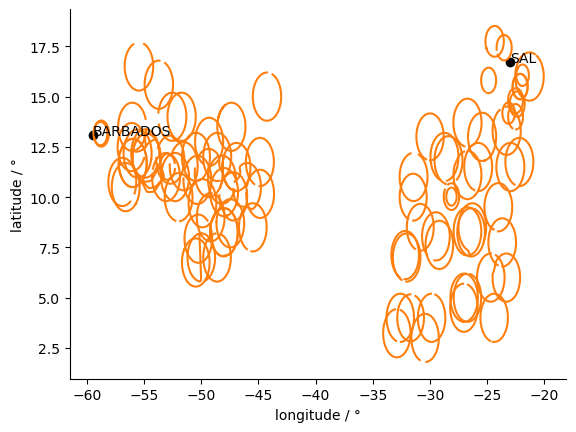

In [10]:
#Plot all Circles
ds = get_halo_position()

fig, ax = plt.subplots()
kind = "circle"

for f in flight_ids:
    for s in segments:
        if kind in s["kinds"] and f==s["flight_id"]:
            t = slice(s["start"], s["end"])
            ax.plot(ds.lon.sel(time=t), ds.lat.sel(time=t), c=kinds2color(kind), label=s["name"])
ax.set_xlabel("longitude / °")
ax.set_ylabel("latitude / °")

ax.scatter(sal.lon, sal.lat, marker="o", color="k")
ax.annotate("SAL", (sal.lon, sal.lat))
ax.scatter(tbpb.lon, tbpb.lat, marker="o", color="k")
ax.annotate("BARBADOS", (tbpb.lon, tbpb.lat))
ax.spines[['right', 'top']].set_visible(False)

Text(0.5, 1.0, 'HALO-20240811a')

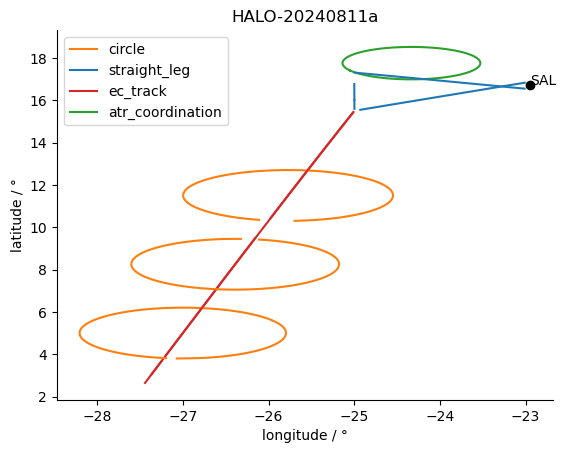

In [11]:
#Plot all segments of a specific flight

ds = get_halo_position()

flight_id = "HALO-20240811a"
fig, ax = plt.subplots()
for s in meta["HALO"][flight_id]["segments"]:
    t = slice(s["start"], s["end"])
    ax.plot(ds.lon.sel(time=t), ds.lat.sel(time=t), c=kinds2color(s["kinds"]))#, label=s["name"])

for k in ["circle", "straight_leg", "ec_track", "atr_coordination"]:
    ax.plot([], [], color=kinds2color(k), label=k)

ax.scatter(sal.lon, sal.lat, marker="o", color="k")
ax.annotate("SAL", (sal.lon, sal.lat))

ax.set_xlabel("longitude / °")
ax.set_ylabel("latitude / °")
ax.spines[['right', 'top']].set_visible(False)
ax.legend()
ax.set_title(flight_id)

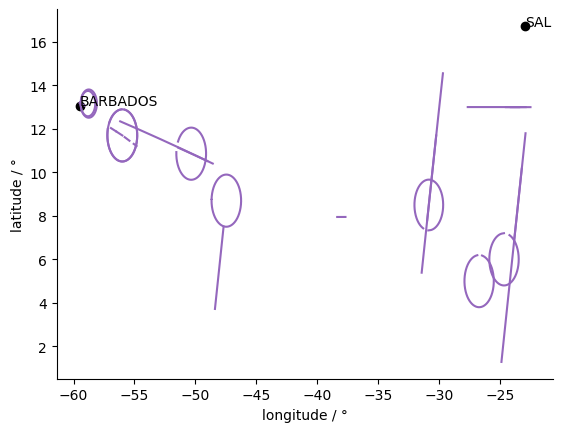

In [12]:
# Plot all Meteor Coordination segments

ds = get_halo_position()

fig, ax = plt.subplots()
kind = "meteor_coordination"

for f in flight_ids:
    for s in segments:
        if kind in s["kinds"] and f==s["flight_id"]:
            t = slice(s["start"], s["end"])
            ax.plot(ds.lon.sel(time=t), ds.lat.sel(time=t), c=kinds2color(kind), label=s["name"])
ax.set_xlabel("longitude / °")
ax.set_ylabel("latitude / °")

ax.scatter(sal.lon, sal.lat, marker="o", color="k")
ax.annotate("SAL", (sal.lon, sal.lat))
ax.scatter(tbpb.lon, tbpb.lat, marker="o", color="k")
ax.annotate("BARBADOS", (tbpb.lon, tbpb.lat))
ax.spines[['right', 'top']].set_visible(False)

In [13]:
#List all Meteor Coordination segments

segment_ids_by_kind["meteor_coordination"]

['HALO-20240821a_15b8',
 'HALO-20240822a_3a8e',
 'HALO-20240827a_b0ad',
 'HALO-20240827a_9002',
 'HALO-20240827a_c759',
 'HALO-20240831a_90bf',
 'HALO-20240831a_6135',
 'HALO-20240903a_b93d',
 'HALO-20240903a_c30f',
 'HALO-20240903a_474e',
 'HALO-20240906a_2a34',
 'HALO-20240916a_719b',
 'HALO-20240916a_ca1c',
 'HALO-20240919a_0ec5',
 'HALO-20240919a_caf1',
 'HALO-20240919a_c457',
 'HALO-20240921a_e08b',
 'HALO-20240921a_4693',
 'HALO-20240921a_8a67',
 'HALO-20240921a_3023',
 'HALO-20240921a_d10b',
 'HALO-20240921a_a71f',
 'HALO-20240923a_6ee3',
 'HALO-20240923a_0f2e',
 'HALO-20240923a_a908',
 'HALO-20240923a_38d6']

In [14]:
# Total time of coordination with Meteor
meteor_time = sum([s["end"] - s["start"]
               for s in segments
               if "meteor_coordination" in s["kinds"]
              ], datetime.timedelta())
print(meteor_time)

14:24:33


In [15]:
#Define events
events = [{**e,
             "platform_id": platform_id,
             "flight_id": flight_id
            }
            for platform_id, flights in meta.items()
            for flight_id, flight in flights.items()
            for e in flight["events"]
           ]

events

[{'event_id': 'HALO-20240809b_1e97',
  'name': 'CVAO overpass',
  'time': datetime.datetime(2024, 8, 9, 15, 24, 59),
  'kinds': ['cvao_overpass'],
  'remarks': [],
  'distance': 1418,
  'platform_id': 'HALO',
  'flight_id': 'HALO-20240809b'},
 {'event_id': 'HALO-20240811a_243c',
  'name': 'EC meeting point',
  'time': datetime.datetime(2024, 8, 11, 15, 51, 53, 745187),
  'kinds': ['ec_underpass'],
  'remarks': [],
  'distance': 1123,
  'platform_id': 'HALO',
  'flight_id': 'HALO-20240811a'},
 {'event_id': 'HALO-20240811a_4cb2',
  'name': 'CVAO overpass',
  'time': datetime.datetime(2024, 8, 11, 19, 12, 15),
  'kinds': ['cvao_overpass'],
  'remarks': [],
  'distance': 558,
  'platform_id': 'HALO',
  'flight_id': 'HALO-20240811a'},
 {'event_id': 'HALO-20240813a_a3f1',
  'name': 'EC meeting point',
  'time': datetime.datetime(2024, 8, 13, 15, 39, 52, 64375),
  'kinds': ['ec_underpass'],
  'remarks': [],
  'distance': 706,
  'platform_id': 'HALO',
  'flight_id': 'HALO-20240813a'},
 {'event

In [16]:
# Meteor overpass events
event_ids_meteor_event = [e["event_id"] for e in events if "meteor_overpass" in e["kinds"]]
times_meteor_event = [e["time"] for e in events if "meteor_overpass" in e["kinds"]]
times_meteor_event

[datetime.datetime(2024, 8, 27, 16, 54, 56, 246625),
 datetime.datetime(2024, 8, 27, 17, 13, 47, 150000),
 datetime.datetime(2024, 8, 27, 17, 33, 0, 238250),
 datetime.datetime(2024, 8, 31, 10, 9, 6, 127437),
 datetime.datetime(2024, 8, 31, 14, 5, 22, 1875),
 datetime.datetime(2024, 9, 3, 13, 21, 57, 1875),
 datetime.datetime(2024, 9, 3, 16, 7, 55, 792125),
 datetime.datetime(2024, 9, 6, 13, 4, 24, 251312),
 datetime.datetime(2024, 9, 16, 17, 26, 25, 713687),
 datetime.datetime(2024, 9, 19, 12, 20, 48, 439187),
 datetime.datetime(2024, 9, 19, 13, 46, 44, 172375),
 datetime.datetime(2024, 9, 21, 12, 57, 34, 911750),
 datetime.datetime(2024, 9, 23, 11, 18, 36, 269312),
 datetime.datetime(2024, 9, 23, 11, 54, 1, 117125),
 datetime.datetime(2024, 9, 23, 12, 26, 11, 620187),
 datetime.datetime(2024, 9, 23, 19, 52, 11, 814750)]

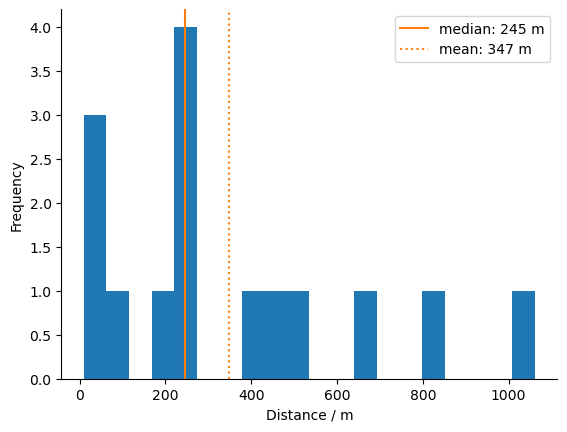

In [17]:
#Histogram of HALO-Meteor distance during overpass meeting points

meteor_dist = [e["distance"] for e in events if "meteor_overpass" in e["kinds"]]

fig, ax = plt.subplots()

#ignore first overpass which is 81248 m distance (80 km?) 
#According to my notes, we did not do an overpass August 21, Meteor was within the northerm part of HALO circle
ax.hist(meteor_dist[1:], bins=20)
ax.axvline(x=np.median(meteor_dist[1:]), c="C1", label=f"median: {int(np.median(meteor_dist[1:]))} m")
ax.axvline(x=np.mean(meteor_dist[1:]), c="C1", ls=":", label=f"mean: {int(np.mean(meteor_dist[1:]))} m")
ax.set_xlabel("Distance / m")
ax.set_ylabel("Frequency")
ax.spines[['right', 'top']].set_visible(False)
ax.legend(loc=0);

In [18]:
meteor_dist

[1, 10, 10, 245, 98, 439, 263, 1061, 176, 680, 511, 43, 242, 244, 814, 379]

(-2.1, 22.1)

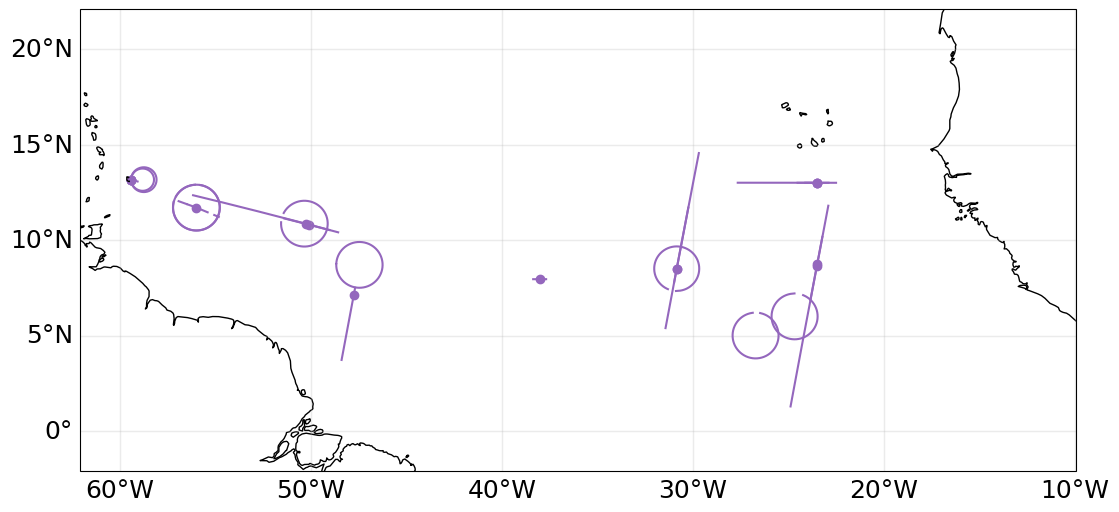

In [20]:
# Plot all Meteor Coordination segments and events

plt.figure(figsize = (18, 6))
kind = "meteor_coordination"
lonMin, lonMax = -62.1, -9.9
latMin, latMax = -2.1, 22.1

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines(resolution = '50m',linewidth=1,alpha=1)
#ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)
gl = ax.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,alpha = 0.25)
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator([-60, -50, -40, -30, -20, -10])
gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 18}
gl.ylabel_style = {'size': 18}

ds = get_halo_position()

for f in flight_ids:
    for s in segments:
        if kind in s["kinds"] and f==s["flight_id"]:
            t = slice(s["start"], s["end"])
            ax.plot(ds.lon.sel(time=t), ds.lat.sel(time=t), c=kinds2color(kind), label=s["name"])
    for e in events:
        if "meteor_overpass" in e["kinds"] and f==e["flight_id"]:
            t = e["time"]
            ax.scatter(ds.lon.sel(time=t,method='nearest'), ds.lat.sel(time=t,method='nearest'),c=kinds2color(kind), label=e["name"])

ax.set_xlim(lonMin,lonMax)
ax.set_ylim(latMin,latMax)

#ax.set_xlabel("longitude / °")
#ax.set_ylabel("latitude / °")

#ax.scatter(sal.lon, sal.lat, marker="o", color="k")
#ax.annotate("SAL", (sal.lon, sal.lat))
#ax.scatter(tbpb.lon, tbpb.lat, marker="o", color="k")
#ax.annotate("BARBADOS", (tbpb.lon, tbpb.lat))
#ax.spines[['right', 'top']].set_visible(False)